<a href="https://colab.research.google.com/github/Jimmy-2016/MetaCognition/blob/main/MetaCognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [3]:
# Read Data
df = pd.read_csv("sampledata.csv")


In [4]:
df.head()


,Unnamed: 0,Coherence,Confidence,ReactionTime,SubResponse,TrueDirection,ACC,SubjectNumber
0,0,6.4,5,2823,180,180,1,1
1,1,6.4,4,4152,180,180,1,1
2,2,12.8,4,4253,0,0,1,1
3,3,6.4,4,3895,180,180,1,1
4,4,6.4,3,3062,0,180,0,1


Text(0, 0.5, 'Accuracy (%)')

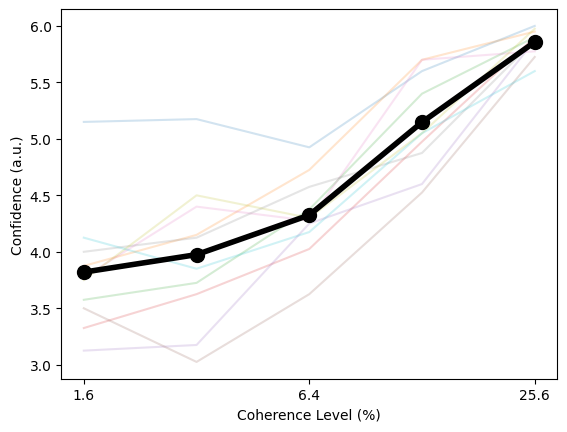

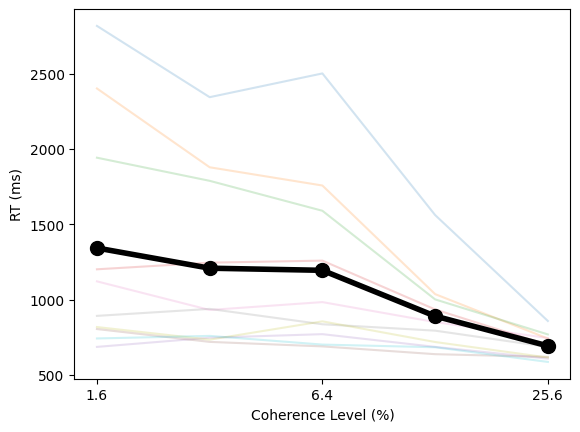

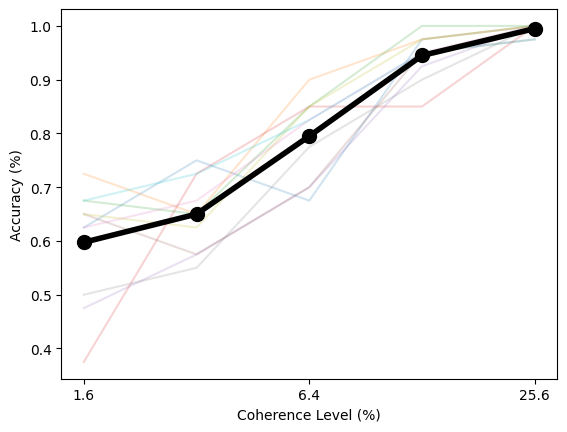

In [11]:
## Plot Behavioral

NumSub = df['SubjectNumber'].unique()
Cohs = np.sort(df['Coherence'].unique())


alpha = 0.2

conf = np.zeros((len(NumSub), len(Cohs)))
Acc = np.zeros((len(NumSub), len(Cohs)))
RT = np.zeros((len(NumSub), len(Cohs)))


for si in range(len(NumSub)):
    tmpdata = df.loc[df['SubjectNumber'] == NumSub[si]]
    for ci in range(len(Cohs)):
      tmpcohdata = tmpdata.loc[tmpdata['Coherence'] == Cohs[ci]]
      conf[si, ci] = tmpcohdata['Confidence'].mean()
      Acc[si, ci] = tmpcohdata['ACC'].mean()
      RT[si, ci] = tmpcohdata['ReactionTime'].mean()



plt.figure()
plt.plot(np.arange(len(Cohs)), conf.T, alpha=alpha)
plt.plot(np.arange(len(Cohs)), conf.mean(0), '.-', ms=20, c='k', lw=4)
plt.xticks([0, 2, 4], ['1.6', '6.4', '25.6'])
plt.xlabel('Coherence Level (%)')
plt.ylabel('Confidence (a.u.)')

plt.figure()
plt.plot(np.arange(len(Cohs)), RT.T, alpha=alpha)
plt.plot(np.arange(len(Cohs)), RT.mean(0), '.-', ms=20, c='k', lw=4)
plt.xticks([0, 2, 4], ['1.6', '6.4', '25.6'])
plt.xlabel('Coherence Level (%)')
plt.ylabel('RT (ms)')

plt.figure()
plt.plot(np.arange(len(Cohs)), Acc.T, alpha=alpha)
plt.plot(np.arange(len(Cohs)), Acc.mean(0), '.-', ms=20, c='k', lw=4)
plt.xticks([0, 2, 4], ['1.6', '6.4', '25.6'])
plt.xlabel('Coherence Level (%)')
plt.ylabel('Accuracy (%)')


In [6]:
# Observe data of one subject

whichSub = 7

tmpdata = df.loc[df['SubjectNumber'] == NumSub[whichSub]]
subConf = tmpdata['Confidence']
subACC = tmpdata['ACC']
corr_conf = subConf[subACC == 1]
err_conf = subConf[subACC == 0]

cf_levels = np.arange(8)

Table = pd.DataFrame(index=['Correct', 'Wrong'], columns=['1', '2', '3', '4', '5', '6', '7'])
for ci in range(1, 8):
        Table.loc['Correct', str(ci)] = np.nansum(corr_conf >= cf_levels[ci]) #/ len(corr_conf)
        Table.loc['Wrong', str(ci)] = np.nansum(err_conf >= cf_levels[ci]) #/ len(err_conf)




In [149]:
Table

,1,2,3,4,5,6,7
Correct,149,149,146,133,106,62,0
Wrong,51,49,43,29,17,4,0


In [7]:
# Main function for calulating MetaCognition

def cal_roc(ACC, Conf, cf_levels):
    num_confs = len(cf_levels)
    c_indx = np.where(ACC == 1)[0]
    err_indx = np.where(ACC == 0)[0]
    corr_conf = Conf[c_indx]
    err_conf = Conf[err_indx]
    totall_correct = len(c_indx)
    totall_err = len(err_indx)

    Hits = np.zeros(num_confs + 1)
    FAs = np.zeros(num_confs + 1)
    for ci in range(0, num_confs):
        Hits[ci] = np.nansum(corr_conf >= cf_levels[ci])/totall_correct
        FAs[ci] = np.nansum(err_conf >= cf_levels[ci])/totall_err



    areas = -np.trapz(Hits, x=FAs)
    return Hits, FAs, areas



In [8]:
# Go through subjects

NumSub = df['SubjectNumber'].unique()
NumConfs = len(df['Confidence'].unique()) + 1
roc_curves = np.empty((len(NumSub)))
roc_curves[:] = np.nan
hits_fa_all = np.empty((2, len(NumSub), NumConfs))
hits_fa_all[:] = np.nan


for si in range(len(NumSub)):
    tmpdata = df.loc[df['SubjectNumber'] == NumSub[si]]

    tmpconf = tmpdata['Confidence'].to_numpy()
    tmpacc = tmpdata['ACC'].to_numpy()

    Hits, FAs, area = cal_roc(tmpacc, tmpconf, np.arange(1, NumConfs))
    roc_curves[si] = area
    hits_fa_all[0, si, :], hits_fa_all[1, si, :] = Hits, FAs


Text(0, 0.5, 'P(Conf|Correct)')

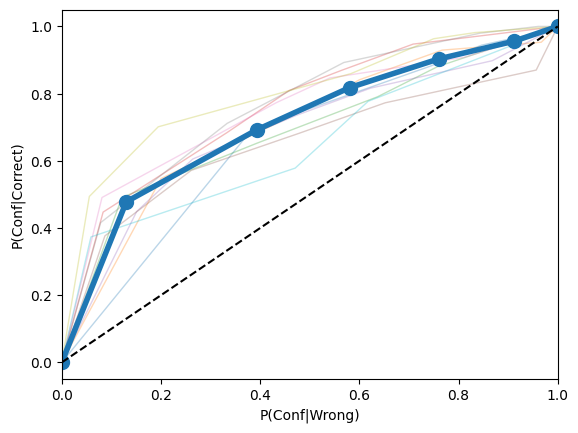

In [10]:
## Plot the Results
plt.figure()

alpha = 0.3
lw = 4

for si in range(len(NumSub)):
    plt.plot(hits_fa_all[1, si, :], hits_fa_all[0, si, :], alpha=alpha, lw=1)


plt.plot(hits_fa_all[1, :, :].mean(0), hits_fa_all[0, :, :].mean(0), '.-', ms=20, lw=lw)


xbin = np.linspace(0, 1, 100)
plt.plot(xbin, xbin, 'k', ls='--')


plt.xlim([0, 1])
plt.xlabel('P(Conf|Wrong)')
plt.ylabel('P(Conf|Correct)')


Text(0, 0.5, 'AOC (a.u.)')

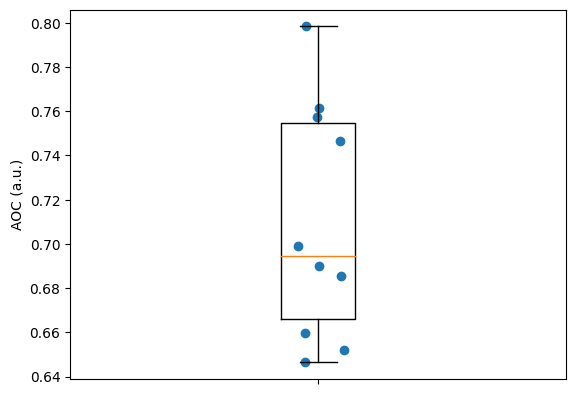

In [152]:
## Areas

plt.figure()

plt.boxplot(roc_curves)
xbins = np.ones(len(roc_curves)) + np.random.normal(0, .03, len(roc_curves))
plt.scatter(xbins, roc_curves)
plt.xticks([1], [''])
plt.ylabel('AUC (a.u.)')